In [4]:
include("../scripts/mcl.jl")

draw (generic function with 7 methods)

In [2]:
mutable struct KldMcl <: AbstractMcl
    particles
    map
    distance_dev_rate
    direction_dev
    motion_noise_rate_pdf
    ml
    pose
    widths
    max_num
    epsilon
    delta
    binnum
end

In [37]:
function KldMcl_(envmap, init_pose, max_num, motion_noise_stds=Dict("nn"=>0.19, "no"=>0.001, "on"=>0.13, "oo"=>0.2),
        distance_dev_rate=0.14, direction_dev=0.05,
        widths = [0.2, 0.2, pi/180], epsilon=0.1, delta=0.01)
    self = KldMcl(ntuple(x->nothing, fieldcount(KldMcl))...)
    self.particles = [Particle(init_pose, 1.0)]
    self.map = envmap
    self.distance_dev_rate = distance_dev_rate
    self.direction_dev = direction_dev
    v = motion_noise_stds
    c = Diagonal([v["nn"]^2, v["no"]^2, v["on"]^2, v["oo"]^2])
    self.motion_noise_rate_pdf = MvNormal(zeros(4), c)
    self.ml = self.particles[1]
    self.pose = self.ml.pose
    self.widths = widths
    self.max_num = max_num
    self.epsilon = epsilon
    self.delta = delta
    self.binnum = 0
    return self
end

KldMcl_ (generic function with 7 methods)

In [53]:
function motion_update(self::KldMcl, nu, omega, time)
    ws = [e.weight for e in self.particles]
    if sum(ws) < 1e-100
        ws = [e + 1e-100 for e in ws]
    end
    new_particles = []
    bins = Set()
    for i in 1:self.max_num
        chosen_p = sample(self.particles, Weights(ws))
        p = deepcopy(chosen_p)
        motion_update(p, nu, omega, time, self.motion_noise_rate_pdf)
        pose_floor = [floor(e) for e in p.pose/self.widths]
        push!(bins, tuple(pose_floor...))
        push!(new_particles, p)
        
        self.binnum = 2
        if length(bins) > 1
            self.binnum = length(bins)
        end
        
        chi2 = Chisq(self.binnum-1)
        if length(new_particles) > ceil(quantile(chi2, 1.0 - self.delta)/(2*self.epsilon))
            break
        end
    end
    
    self.particles = new_particles
    for i in 1:length(self.particles)
        self.particles[i].weight = 1.0/length(self.particles)
    end
    
end

motion_update (generic function with 3 methods)

In [54]:
function observation_update(self::KldMcl, observation)
    for p in self.particles
        observation_update(p, observation, self.map, self.distance_dev_rate, self.direction_dev)
    end
    set_ml(self)    
end

observation_update (generic function with 3 methods)

In [55]:
function draw(self::KldMcl, ax, elems)
    #TODO: call AbstractMcl draw
    xs = [p.pose[1] for p in self.particles]
    ys = [p.pose[2] for p in self.particles]
    vxs = [cos(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    vys = [sin(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    elems = vcat(elems, ax.quiver(xs, ys, vxs, vys, angles="xy", scale_units="xy", color="blue", alpha=0.5))
    
    s = @sprintf("(%d, %d)", length(self.particles), self.binnum)
    elems = vcat(elems, ax.text(-4.5, 4.5, s, fontsize=10))
end

draw (generic function with 8 methods)

In [56]:
function trial()
    time_interval = 1.0
    world = World_(30, time_interval, false)
    
    m = Map()
    for ln in [[2.0, -3.0], [3.0, 3.0]]
        append_landmark(m, Landmark(ln))
    end
    append(world, m)
    
    initial_pose = [0.0, 0.0, 0.0]
    pf = KldMcl_(m, initial_pose, 1000)
    a = EstimationAgent_(time_interval, 0.2, 10.0/180*pi, pf)
    r = Robot_(initial_pose, sensor=Camera_(m), agent=a, color="red")
    append(world, r)
    draw(world)
    showanim("test.mp4")
end

trial (generic function with 1 method)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQABTpVtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAGCtliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80I0ms/W0jh/eawz+oh7ToEdQu/WlFADI0FeNmCtNRv7KQk/tz3AopPZxSsdf1e40v0iiS8By9tDBd3PF+BqrcUDZgeo5PIsSfzDn8ZiS/F9R8iz47/TI4bfoAmQix6MlPry9KzaPmr26HfdA0P2Cef6v4Dm0sW5VB5EliYfJbCgAUcX/K0UmBNL+Tqf9zwT/hylCHhd9ZXBAhMYLYm/X3hIb3CjcphHwOWPIb89+FbzSPfv4FP7zA9bYhzh7R7ZV6TT8GIQ0wl+zEXAnJoUfiqmAIKOFkyBbN021BHePlsK8oNpM5BRKAPmalV9IqR6c1pv1hD11xaVBMFeOAjN6DVaO+YMMrb6oLAaUidUV/UGG8uftDnDJCfbarSNz9yZjwcdhRxRexhqfoYUksAFqJmoWXj+BJ2OvOMYrq5g2xomxnoXVEPrbWrBuYNNL7IwADO0cHQWU7dkCGFy4DnwQFU7yc8Fxev5o5mYxWJG6GJQ7V0iHG4h9CSRh9JHewnpV4PjiWJewt3isAz53sNYJluu1UGSwIjrnick6lEvXIHCzRI+0rQPrq+vxbtdiC2LPVQ+bFHrKuYBAA8iI2g9rTMuDfjrwupCe3KUcbQa6rv+3ck48fTyWtHn73hClJPG37TbAoGmgMd4M1zldjm8rL/GZX4t5TS8Mc6x4bbEn0sZkM/08NOhZr57TIX+Ao2dns9osxN2VxUgUZ0CoZld4BWVtfgeL69KjDogB6VaBddYeSYj0Af71VNKy+bTK54XDyBxf/5CHkkLr6aiggEPq3NXUzo8GN29C4XOaE9gHSDnAxL/gq/q8DRb3Wj6mDsrA3iFm9ykdwjCJOwiQA96sO7uKCCg2tWnD1rPPMjDTa5vIJhN/2UfignfVJlXMw/3iVwrlZmzBcaP9j+8elYRwqz9KQHh7w3CyCKcviEPC9HyhSQIvu+UzHnRJ5KqW6zmAstwhPd/TssFEP8Uk5DMPuTHnvYp5epz8vHHlTT3awuCpBEpgLgwP5rdMuq0rPW9FrjlIGf53kwWwWOWO7klz9y6XP9TEIszw1DyZMieFUxWsX2dExoHUjJC8kQKBmwGc0XF7LUGiXGrhdPGNPuPm/DtK2Hmf6saKHPmO11pmvbfJXcO7rZD24BW/h3WX2U9sehBXgXKOdEDBK9hu09Wi/P5IusmzhWovlH/RA0Qp2Ypow6iL71YMjJ4vrjSiH7HJUC7Kr4j1bDwMqDH7hc6U2K2IC0Sv9CkikWtGCd8ldtrcq0DH2oceZ5PN9r3l6FrmQLrt51RZ3yEW4X5cg5zH7gY7NCXyZB0l4i0SX+WQ/vYJSu9zeG/9Wzw2e6puNbqbECS/0b3f3ODQ1wHP2UCgMVzbg0qOkStwxj5Q6VxGKwu1A8luyh6CG86Tcwg7qFJnY2laV4Qi/nUP1fgRgZOoEdYVizZz02ma4Cp0Lg3bhm70bJpmE3BOFXjG3MaXzMEGUy49bTAXCPGvZhNIgEiVkWhfKut1xrjg+IV7rUo7iNjfSbteEqogw1Uh2+Q7zHufzCWo/OjBFnoQHFsUwrgaKm6ZU5ZizNAQsahsjpPxcmJlD0PbE4XeI+Y+IHDOz8FE37CjPv81KvW6XAP8mnY1Ataw58wm6e5bJGPELZ36eQ+JdPXWgETibMp6Y1sXnnmtvax3MLM3lg3G+h4QyyJM900lnIKIXdMr4KG4JQ+zO8JcpdTDPcR2cMMTfPJWyIOjSFyX7Bw4S4J4eXV52e8tGofcqRJ0c9IS9fhGTxPTXcTL2kSzMb6g1o/EjaBylucoCAGPxe3aKrBhvxu6ThGKqXpUgQZ8nvjGiHC3yu8DmPDt/2dOPmcH4YnDfllXHw6mBnFGWtv1p4tGMIAgiBKd+p9BobF9b6mfoHt0X/jt8nRN8XPthT3VMA6+58tP3davVmMHwcB//JiGFyFJtE9Ztsr/ijvQoc3zEeuoA6m4CJc2skbe0WNYo4LZ+CTKCsssCUtrQZArsCnrPsDrfXhD6+yHQFwjwXKzUAXM4FjLfdKb3s2AiBKoddEPGCTha2sBfJeDcjKzKSPctZsAVPmiBezhk+ipVxNzNCmwKkR494hT5pFll2fTZV6FBbldo0VI3eZJ8VRraJzHWyJxotsMVChmNLgIvtjxcSYghmNTRkrzO8+HClmeq3juQEILMZk1A4GOSbykGuLMuaK6LHaVTbSO6eOx5P7WoIlZ9E6OCQLCD6qtGX6SddgMMYeHCyoPBBaYcepYqjMEMJkgbNF/RWXT2GTvF52c/i3Zxy2zyFz5kn+eLdRFqwPdnEpHT/WGYx30wZu3BmPfCSFUn0Xmwmb/lizfQ4dQjdZsvatzcpYlpbLAHvs8ofAlrbFlbYbhPuOsgQOvlllGLlET8VBa02ktcdCpQ7KxnZdIGsaRPyy3ww0oBpEM+5pyZmeiCV8G37Aeyb3Ld83hk/8Xayh+5ImGMT5zbF12DMTrixissa1QvN4Ak43h82SsEhEdBjt/19muZBi1EY5R98WSme1dqpRVtdHGRtjOacVo6V2vAR0Ma09zvndk5sC+yQI58u82c/Xh+FJclfBt9OnnpNtG0ibcYIwejkTgnIGcLHFST43TLUl98dA1/jdJew23+JDDF/LSw9K4q1ImJ23wTddViGQcIjpVsfMA4FAMkZIdYcB3qeH9VxRTpVUOxev5961hnMIVB9TJFFbWEMmp0l3OXD4G66a4qOBfZC7UJWOUZNsFvvn6ywOqSRxzmLdMG/WBlst1ra3lZ6tXsWXpSTH7cCEm2LieY4+x3M6bEQ+5VE8L

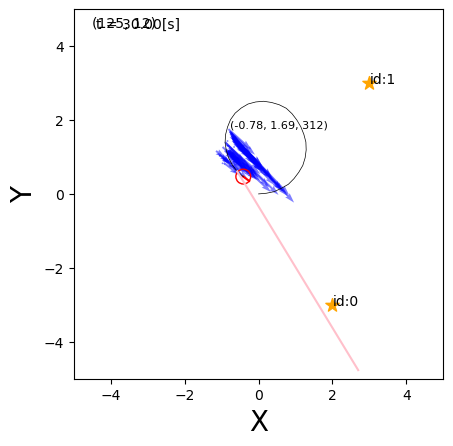

In [57]:
trial()